In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline

# Dimension reduction and clustering libraries
import umap
import sklearn.cluster as cluster
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv('./class-mat.csv')

In [2]:
def draw_umap(data, n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', title=''):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric,
        n_epochs=2000,
        random_state=3308004
    )
    u = fit.fit_transform(data);
    fig = plt.figure()
    if n_components == 1:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], range(len(u)), c=data)
    if n_components == 2:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], u[:,1])
    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(u[:,0], u[:,1], u[:,2], c=data, s=100)
    plt.title(title, fontsize=18)

Let's do a hyperparameter scan of the relevant UMAP parameters to find the best embedding of our data. First, we'll scale the nearest neighbors

/Users/nlubock/miniconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/Users/nlubock/miniconda2/envs/py36/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding 2 connected components using meta-embedding (experimental)
  n_components
/Users/nlubock/miniconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


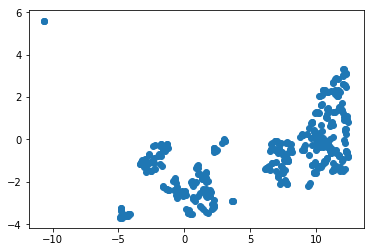

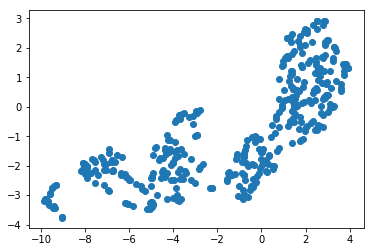

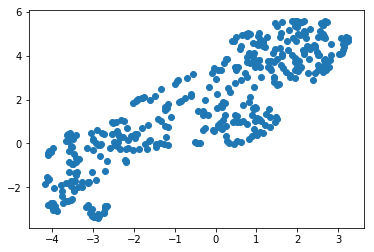

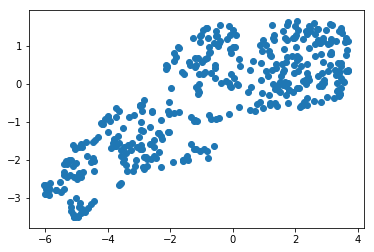

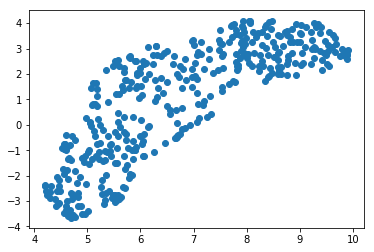

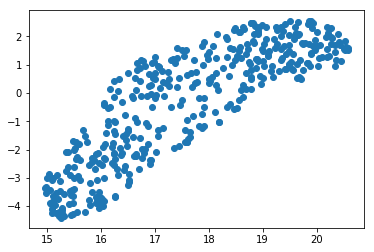

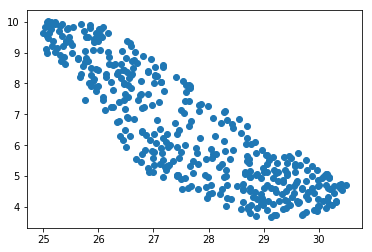

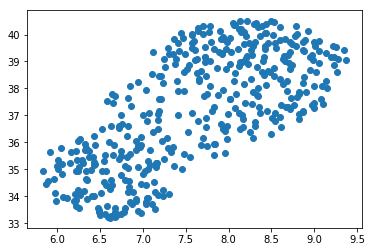

In [3]:
for n in (3, 4, 6, 8, 16, 32, 64, 128):
    draw_umap(df, n_neighbors=n, min_dist=0.05)

We see that there are broadly two clusters in our data (note their emergence as we up the n_neighbors parameter). At low n_neighbors, more of the local strucutre emergers. Let's go with NN=4 as 3 probably is too locally focused. Here we'll scan the min_dist parameter at n_neighbors=4

/Users/nlubock/miniconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


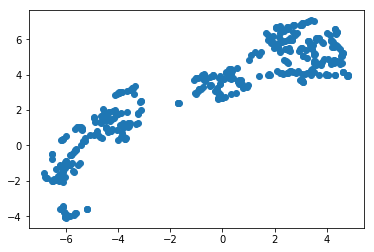

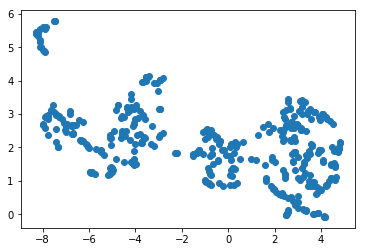

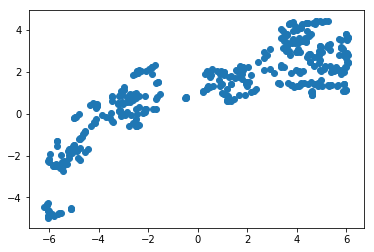

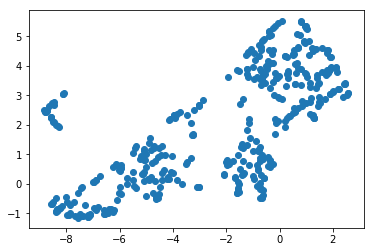

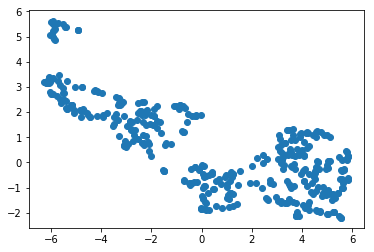

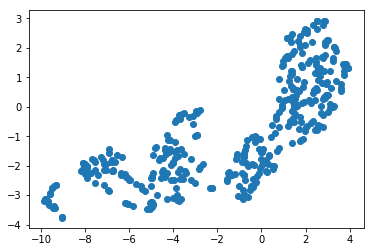

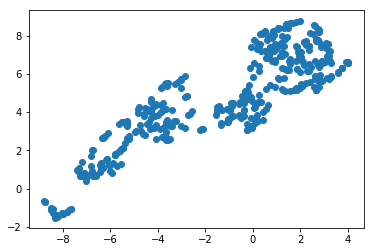

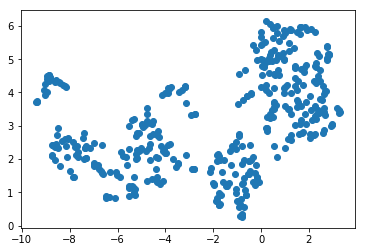

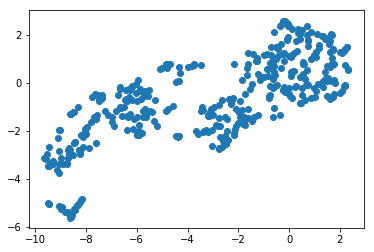

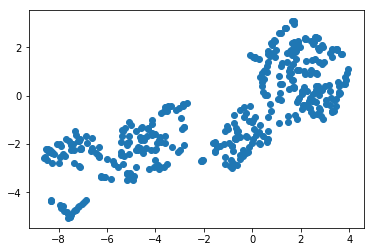

In [4]:
for n in np.arange(0.0, 0.1, 0.01):
    draw_umap(df, n_neighbors=4, min_dist = n)

Roughly speaking, the clustering does not seem to change too much as we up the min_dist parameter. Let's go with 0 for now to allow the points to be as close together as possible.

/Users/nlubock/miniconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


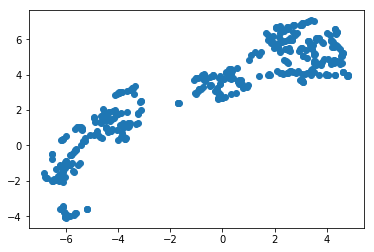

In [5]:
final_fit = umap.UMAP(
    n_neighbors=4, 
    min_dist=0, 
    n_components=2,
    n_epochs=2000,
    random_state=3308004)

u4 = final_fit.fit_transform(df)
plt.scatter(u4[:,0], u4[:,1])

In [6]:
pd.DataFrame(u4).to_csv('./umap-embed.csv')

# Appendix

How does UMAP perform on random data of similar dimension to ours?

/Users/nlubock/miniconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/Users/nlubock/miniconda2/envs/py36/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding 38 connected components using meta-embedding (experimental)
  n_components


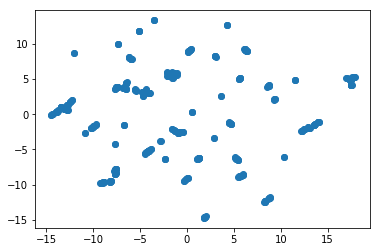

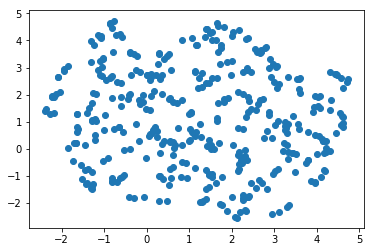

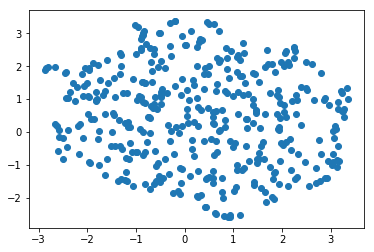

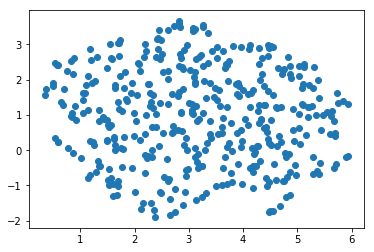

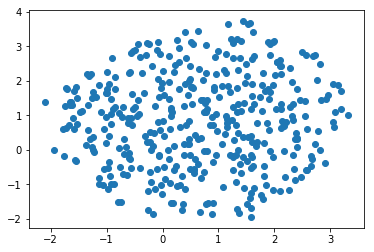

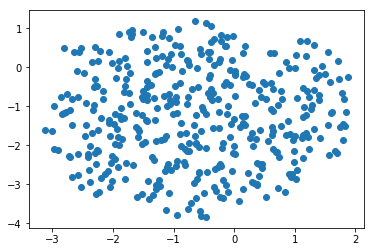

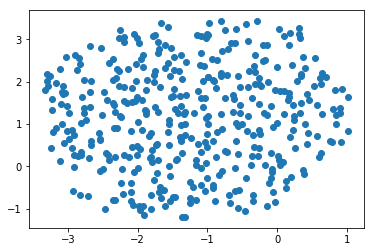

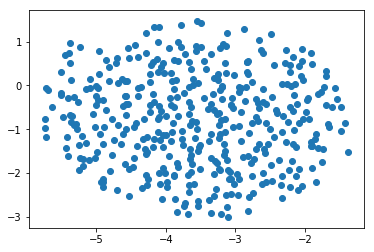

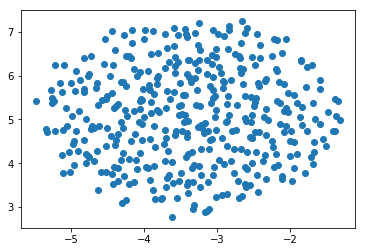

In [7]:
rand_80 = np.random.multivariate_normal(np.zeros(80), np.eye(80), size=400)
for n in (2,3,4,5,6,8,16,32,64):
#for x, n in enumerate(np.arange(0.0, 1.0, 0.1)):
    fit = umap.UMAP(n_neighbors=n, min_dist=0.1, n_components=2).fit_transform(rand_80)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(fit[:,0], fit[:,1])

Let's use HDBSCAN to cluster our data in the 2D embedding

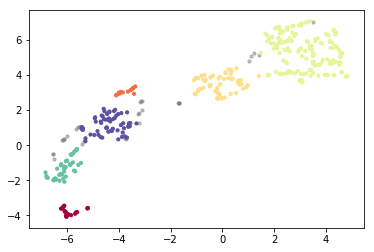

In [8]:
import hdbscan
hdb = hdbscan.HDBSCAN(min_cluster_size = 10)
hdbscan_labels = hdb.fit_predict(u4)
clustered = (hdbscan_labels >= 0)
plt.scatter(u4[~clustered, 0],
            u4[~clustered, 1],
            c=(0.5, 0.5, 0.5),
            s=10,
            alpha=0.5)
plt.scatter(u4[clustered, 0],
            u4[clustered, 1],
            c=hdbscan_labels[clustered],
            s=10,
            cmap='Spectral');